 **Data Preprocessor**

In [1]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Sequential class
#   from the Keras library is a model that allows you to build a neural network layer by layer.
# 
# ImageDataGenerator class  
#   from the Keras library is a utility for generating batches of tensor image data with real-time data augmentation. 
#   This can be useful for increasing the diversity of the training data, which can help to improve the performance of the model.
# 
# Conv2D, MaxPooling2D, Dense, Dropout, and Flatten classes 
#   from the Keras library are layers that can be added to the model. Conv2D is a 
#   convolutional layer that applies a convolution operation to the input, MaxPooling2D is a pooling layer that down-samples the input, 
#   Dense is a fully connected layer that flattens the input and applies a linear transformation, Dropout is a layer that randomly sets a 
#   fraction of the input units to 0 at each update during training to help prevent overfitting, and Flatten is a layer that flattens the input.
# 
# Adam class 
#   from the TensorFlow library is an optimization algorithm that can be used to update the model's weights during training.
# 
# matplotlib library 
#   is a plotting library for Python, and the plt module provides functions for creating and customizing plots.
# 
# The os library 
#   provides functions for interacting with the operating system, such as for finding files and directories.
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os


#set the train & test data paths 
train_data_path = '/kaggle/input/fer2013/train/'
test_data_path = '/kaggle/input/fer2013/test/'

batch_size = 64
epochs = 100



In [2]:
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# preparing data for analysis by cleaning, formatting, and transforming in order to fit into input_shape of the CNN
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def dataPreProcessor():    

    # train_datagenerator is an instance of the ImageDataGenerator class that is initialized with the rescale argument set to 1./255.
    # The rescale argument specifies a rescaling factor to be applied to the image data before it is passed to the model.
    # In this case, the image data will be rescaled by dividing each pixel value by 255. This is often done to normalize the pixel values,
    # which typically have values between 0 and 255, to a range between 0 and 1.
    train_datagenerator = ImageDataGenerator(rescale=1./255)
    test_datagenerator = ImageDataGenerator(rescale=1./255)


    # train_generator is being set to a generator, that generates batches of data from the directory train_data_path for training.
    # The generator will convert the images to grayscale and resize them to have dimensions of (48, 48).
    # The generator will also return the labels for the images in a one-hot encoded categorical format and will shuffle the data
    # before returning batches of size 64.
    train_generator = train_datagenerator.flow_from_directory(train_data_path,
                                                              color_mode='grayscale',
                                                              target_size=(48,48),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

    test_generator = test_datagenerator.flow_from_directory(test_data_path,
                                                            color_mode='grayscale',
                                                            target_size=(48,48),
                                                            batch_size=batch_size,
                                                            class_mode='categorical')


    # train_generator is an object that generates a sequence of data, where each element consists of an image (img) and a label (label).
    # The __next__ method is used to retrieve the next element in the sequence.
    img, label = train_generator.__next__()
   
    return train_generator, test_generator


CNN model

In [3]:
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# This mfuntion defines a convolutional neural network (CNN) using the Keras API. The network consists of four convolutional layers, three max pooling layers, 
# and three dropout layers, followed by a fully connected layer, another dropout layer, and a classification and output layer.
# The input to the model is expected to be 48x48 pixel grayscale images with one channel, and the output is a probability distribution over 7 categories. 
# The model will use the Adam optimizer with a specified learning rate and decay, and it will be trained using categorical cross-entropy loss and accuracy as metrics.
# The model.summary() method will print a summary of the model architecture, and will return the model as the put pu to the TrainAndValidate() function.
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def FeatureExtraction():
    
    model = Sequential()
    
    # Convolution layer 1
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(48,48,1))) #1 means gray scale.. #32 means aplly filters
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25)) #25% dropout
    
    # Convolution layer 3, pooling layer, dropout layer
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Fully connected layer
    model.add(Flatten())  # 3d array comes from here and convert to 1D array
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    
    # classification and output layer
    model.add(Dense(7, activation='softmax')) #7means catergories (sad, happy....)
    
    #compile and print the model data
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'] )
    print(model.summary())

    return model


In [4]:
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# The 'fit' method of the 'model' object to train the model on the training data. The training data is generated by the 'train_generator' object, 
# which generates batches of data from the 'train_data_path' directory. The number of steps per epoch is set to the number of training images divided by 64, 
# which is the batch size. # The number of epochs is set to the value of the 'epochs' variable (which is 100 in this case).
#The model is also validated on the test data generated by the 'test_generator' object. The number of validation steps is set to the number of test images divided by 64.
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def TrainAndValidate(model, train_generator, test_generator):
    
    #Counting the number of images in the 'train_data_path' and 'test_data_path' directories 
    num_train_images = 0
            
    for root, dir, files in os.walk(train_data_path):
        num_train_images += len(files)

    num_test_images = 0
    for root, dir, files in os.walk(test_data_path):
        num_test_images += len(files)


    result = model.fit(train_generator,
                        steps_per_epoch=num_train_images//batch_size,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=num_test_images//batch_size)
    
    # save the model
    model.save('/kaggle/working/fer2013_100epochs.h5')
    
    return result   

In [5]:
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Line plots graphs to show the acuracy of trained model
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def DataVisualization(result):
    
    # checking the train and test loss and accuracy
    train_loss = result.history['loss']
    test_loss = result.history['val_loss']
    train_accuracy = result.history['accuracy']
    test_accuracy = result.history['val_accuracy']

    # visualize the loss and accuracy in a line chart
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))
    ax = ax.ravel()

    ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize='5')
    ax[0].plot(test_loss, label='Test Loss', color='orangered', marker='o', markersize='5')

    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Categorical Corssentropy', fontsize=14)

    ax[0].legend(fontsize=14)
    ax[0].tick_params(axis='both', labelsize=12)

    ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize='5')
    ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize='5')

    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Categorical Corssentropy', fontsize=14)

    ax[1].legend(fontsize=14)
    ax[1].tick_params(axis='both', labelsize=12)

    fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss adn accuracy of CNN model by epochs", fontsize=16)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


2023-02-18 07:35:28.494593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 07:35:28.592610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 07:35:28.593414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 07:35:28.594579: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

2023-02-18 07:35:39.139155: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-02-18 07:35:41.228607: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


448/448 [==============================] - 244s 529ms/step - loss: 1.8012 - accuracy: 0.2580 - val_loss: 1.7184 - val_accuracy: 0.3318
Epoch 2/100
448/448 [==============================] - 34s 75ms/step - loss: 1.6298 - accuracy: 0.3668 - val_loss: 1.5434 - val_accuracy: 0.4113
Epoch 3/100
448/448 [==============================] - 34s 75ms/step - loss: 1.5294 - accuracy: 0.4148 - val_loss: 1.4717 - val_accuracy: 0.4297
Epoch 4/100
448/448 [==============================] - 33s 73ms/step - loss: 1.4619 - accuracy: 0.4415 - val_loss: 1.4067 - val_accuracy: 0.4633
Epoch 5/100
448/448 [==============================] - 33s 74ms/step - loss: 1.3998 - accuracy: 0.4680 - val_loss: 1.3701 - val_accuracy: 0.4756
Epoch 6/100
448/448 [==============================] - 33s 74ms/step - loss: 1.3477 - accuracy: 0.4876 - val_loss: 1.3186 - val_accuracy: 0.4997
Epoch 7/100
448/448 [==============================] - 33s 74ms/step - loss: 1.3042 - accuracy: 0.5069 - val_loss: 1.2801 - val_accuracy: 0.

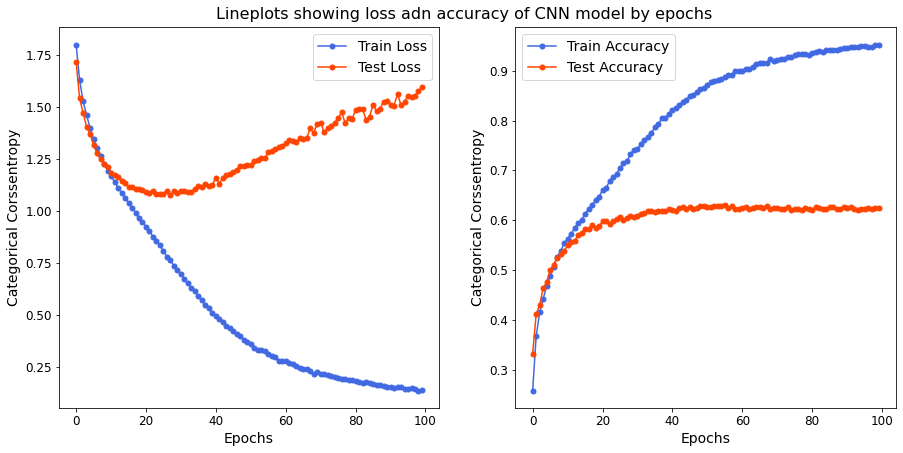

In [6]:
#call the methods
train_generator, test_generator = dataPreProcessor()
model = FeatureExtraction()
result = TrainAndValidate(model, train_generator, test_generator)
DataVisualization(result)